In [8]:
### using python 3.10.5
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline
from scipy.stats import skew
# from scipy.stats import kurtosis
from scipy.stats import chi2_contingency
from matplotlib import pyplot as plt 
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate


In [2]:
### import the data
# there are no headers in the file so they will be imported separately and then appended to the train/test data
# get columns before importing data so we can assign the column headers at import, you can either extract from the txt file or copy it over
# we need to remove the columns containing '| instance weight' according to the instructions and add a column header for the target variable

path_train = r"C:\Users\wausa\Downloads\drive-download-20250217T195304Z-001\census_income_learn.csv"

headers = ['age', 'class of worker', 'detailed industry recode', 'detailed occupation recode', 'education', 'wage per hour', 'enroll in edu inst last wk', 'marital stat',
           'major industry code', 'major occupation code', 'race', 'hispanic origin', 'sex', 'member of a labor union', 'reason for unemployment',
           'full or part time employment stat', 'capital gains', 'capital losses', 'dividends from stocks', 'tax filer stat', 'region of previous residence',
           'state of previous residence', 'detailed household and family stat', 'detailed household summary in household', '| instance weight', 'instance weight',
           'migration code-change in msa', 'migration code-change in reg', 'migration code-move within reg', 'live in this house 1 year ago', 'migration prev res in sunbelt',
           'num persons worked for employer', 'family members under 18', 'country of birth father', 'country of birth mother', 'country of birth self', 'citizenship',
           'own business or self employed', "fill inc questionnaire for veteran's admin", 'veterans benefits', 'weeks worked in year', 'year']
headers.remove('| instance weight')
headers.append('target') # the final column is the target variable

continuous_data = ['age', 'wage per hour', 'capital gains', 'capital losses', 'dividends from stocks', 'num persons worked for employer', 'weeks worked in year']

df = pd.read_csv(path_train, names=headers)
df.shape

# check the number of records and features

(199523, 42)

In [3]:
# look at the continuous data, to determine figures asssoicated to each feature
df.describe()

# number of missing datapoints for each feature 
df.isnull().sum().value_counts() # shown as zero but looking at the data we have a number of missing records marked as '?' or so we 
# will replace the '?' values with NaN. It is also helpful to make the values NaN for encoding later.


0    42
Name: count, dtype: int64

In [4]:
df = df.replace('?', np.nan) # we can see now that the empty values are now accounted for

# data is full of whitespaces so they will be removed
df = df.map(lambda x: x.strip() if isinstance(x, str) else x)


In [5]:
# the target column has been split into two columns (value +50,000 or -50,000), 
# we can avoid this by just converting the value to 1 or 0 in the column. The column is a string so we can just use the string value as the condition

df['target'] = df['target'].apply(lambda x: 0 if x == '- 50000.' else 1)
df['target'].value_counts()

# imbalance in the target classes so we need to consider using some alternative method of evaluating the results aside from the 
# standard confusion matrix, something like an ROC curve

# it may be pertinent to separate the data into numerical and categorical variables to determine the correlations between variables as 
# from the metadata we can see what variables are continues and which are nominal (outlined at the top of the file)

df_continuous = df[continuous_data] # 7 continuous features
df_categorical = df.drop(continuous_data, axis=1) # 35 categorical features
df_categorical = df_categorical.astype('category')


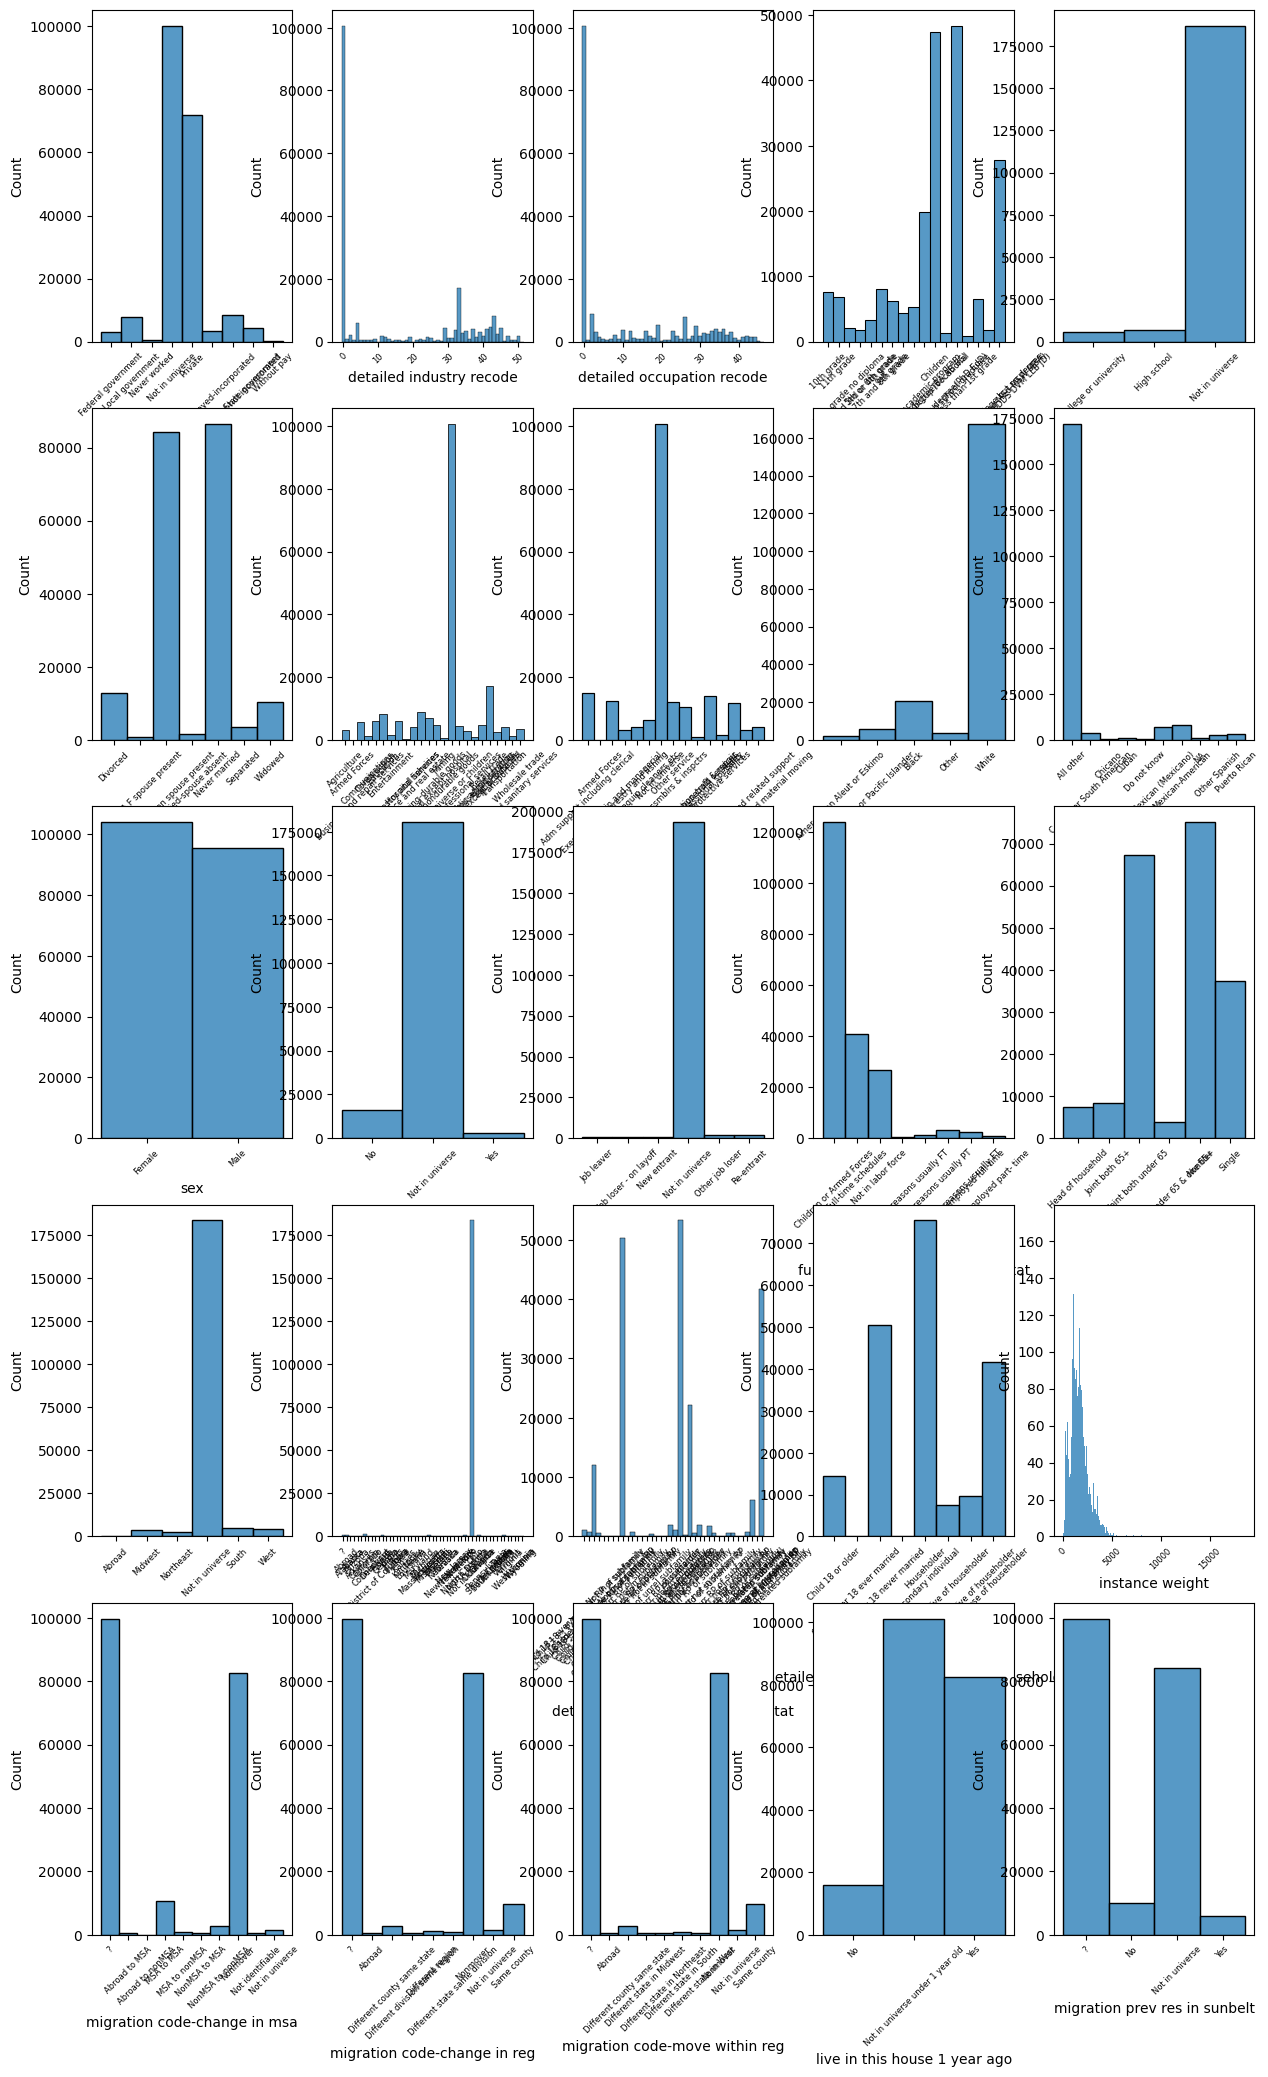

In [6]:
# there are 35 categorical features, which is high and will get higher if we use one hot encoding for example when we need to process the data
# we can visualise the data
# We have a large amount of zero values, 
# but those zeroes are useful records and indicative of actual values such as when 'wage per hour' is zero, it 
# is due to uneployment

fig, ax = plt.subplots(5, 5)
ax = ax.flatten()         # Convert axes to 1d array of length 9
fig.set_size_inches(15, 25)

for ax, col in zip(ax, df_categorical.columns):
  sns.histplot(df_categorical[col], ax = ax,)
  ax.tick_params(axis='x', labelrotation=45, labelsize=6)

In [9]:
# there's a lot of categorical variables, and we can use 
# correlation to determine if we can reduce the feature count

# we can view this correlation using Cramers V test, which is used to 
# calcualte the correlation between categorical values, in this 
# example, those which are nominal

def cramers_v(confusion_matrix):
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - (k-1)*(r-1)/(n-1))
    rcorr = r - (r-1)**2/(n-1)
    kcorr = k - (k-1)**2/(n-1)
    return np.sqrt((phi2corr / min( (kcorr-1), (rcorr-1))))

# one example of categorical variable correlation
contingency = pd.crosstab(df_categorical['region of previous residence'], df_categorical['state of previous residence']).values
cramers = cramers_v(contingency)
print(f'Cramer\'s V correlation for \'region of previous residence\' and \'state of previous residence\' is {cramers}')


Cramer's V correlation for 'region of previous residence' and 'state of previous residence' is 0.9659972276542771


<Axes: >

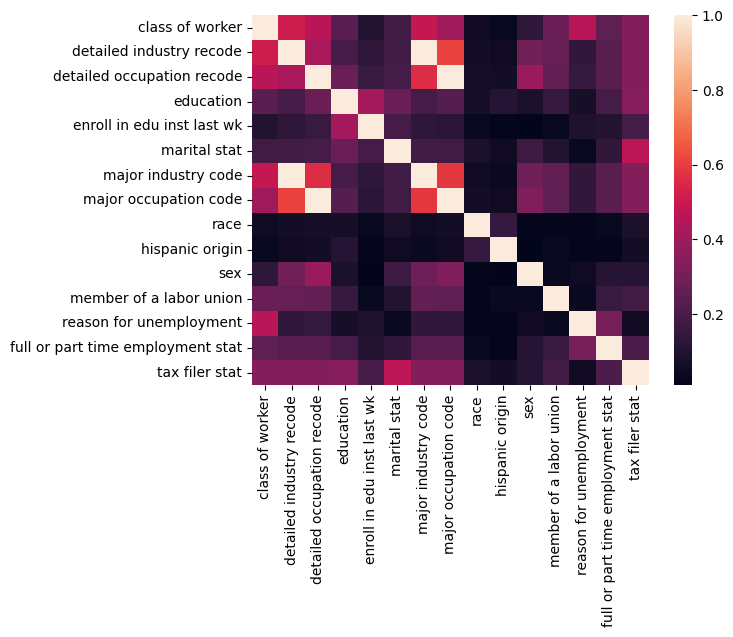

In [10]:
# determine the correlation for the categorical features using Cramer's V

df_categorical_first15 = df_categorical.iloc[:, 0:15] # first 15 features, not enough memory to compare them all visually

rows= []
for var1 in df_categorical_first15:
    col = []
    for var2 in df_categorical_first15 :
        contingency = pd.crosstab(df_categorical_first15[var1], df_categorical_first15[var2]).values
        cramers = cramers_v(contingency)
        col.append(round(cramers,2))
    rows.append(col)

cramers_results = np.array(rows)
cramers_df = pd.DataFrame(cramers_results, columns = df_categorical_first15.columns, index =df_categorical_first15.columns)

sns.heatmap(cramers_df)

In [11]:
# we can drop the highly correlated fields to reduce the number of features
# i.e., detailed industry recode and detailed occupation recode, major industry code and major occupation code, 
# detailed household and family stat and detailed household summary in household
# migration code-change in msa, migration code-change in reg, migration code-move within reg, migration prev res in sunbelt
# fill inc questionnaire for veteran\'s admin and veterans benefits

corr_cols_to_remove = ['detailed occupation recode', 'major occupation code', 'detailed household summary in household', 'migration code-change in msa', 
                     'migration code-change in reg', 'migration code-move within reg', 'migration prev res in sunbelt', 'fill inc questionnaire for veteran\'s admin', 
                     'region of previous residence']

df = df.drop(corr_cols_to_remove, axis=1) # remove columns from original df

df_categorical = df_categorical.drop(corr_cols_to_remove, axis=1)


<Axes: >

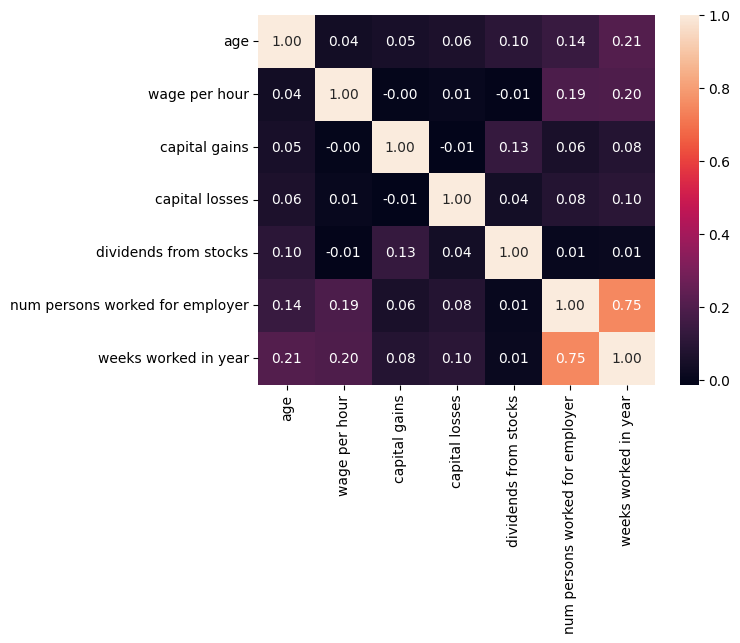

In [12]:
# for numerical values we can immediately view the correlation as a heatmap

sns.heatmap(df_continuous.corr(), annot=True, fmt='.2f')

# we can see the numerical values are not necessarily correlated aside from 'number of persons worked for employer'/'weeks worked' 
# which has a fairly strong correlation at 0.75. We will keep all columns as the correlation is not that extreme

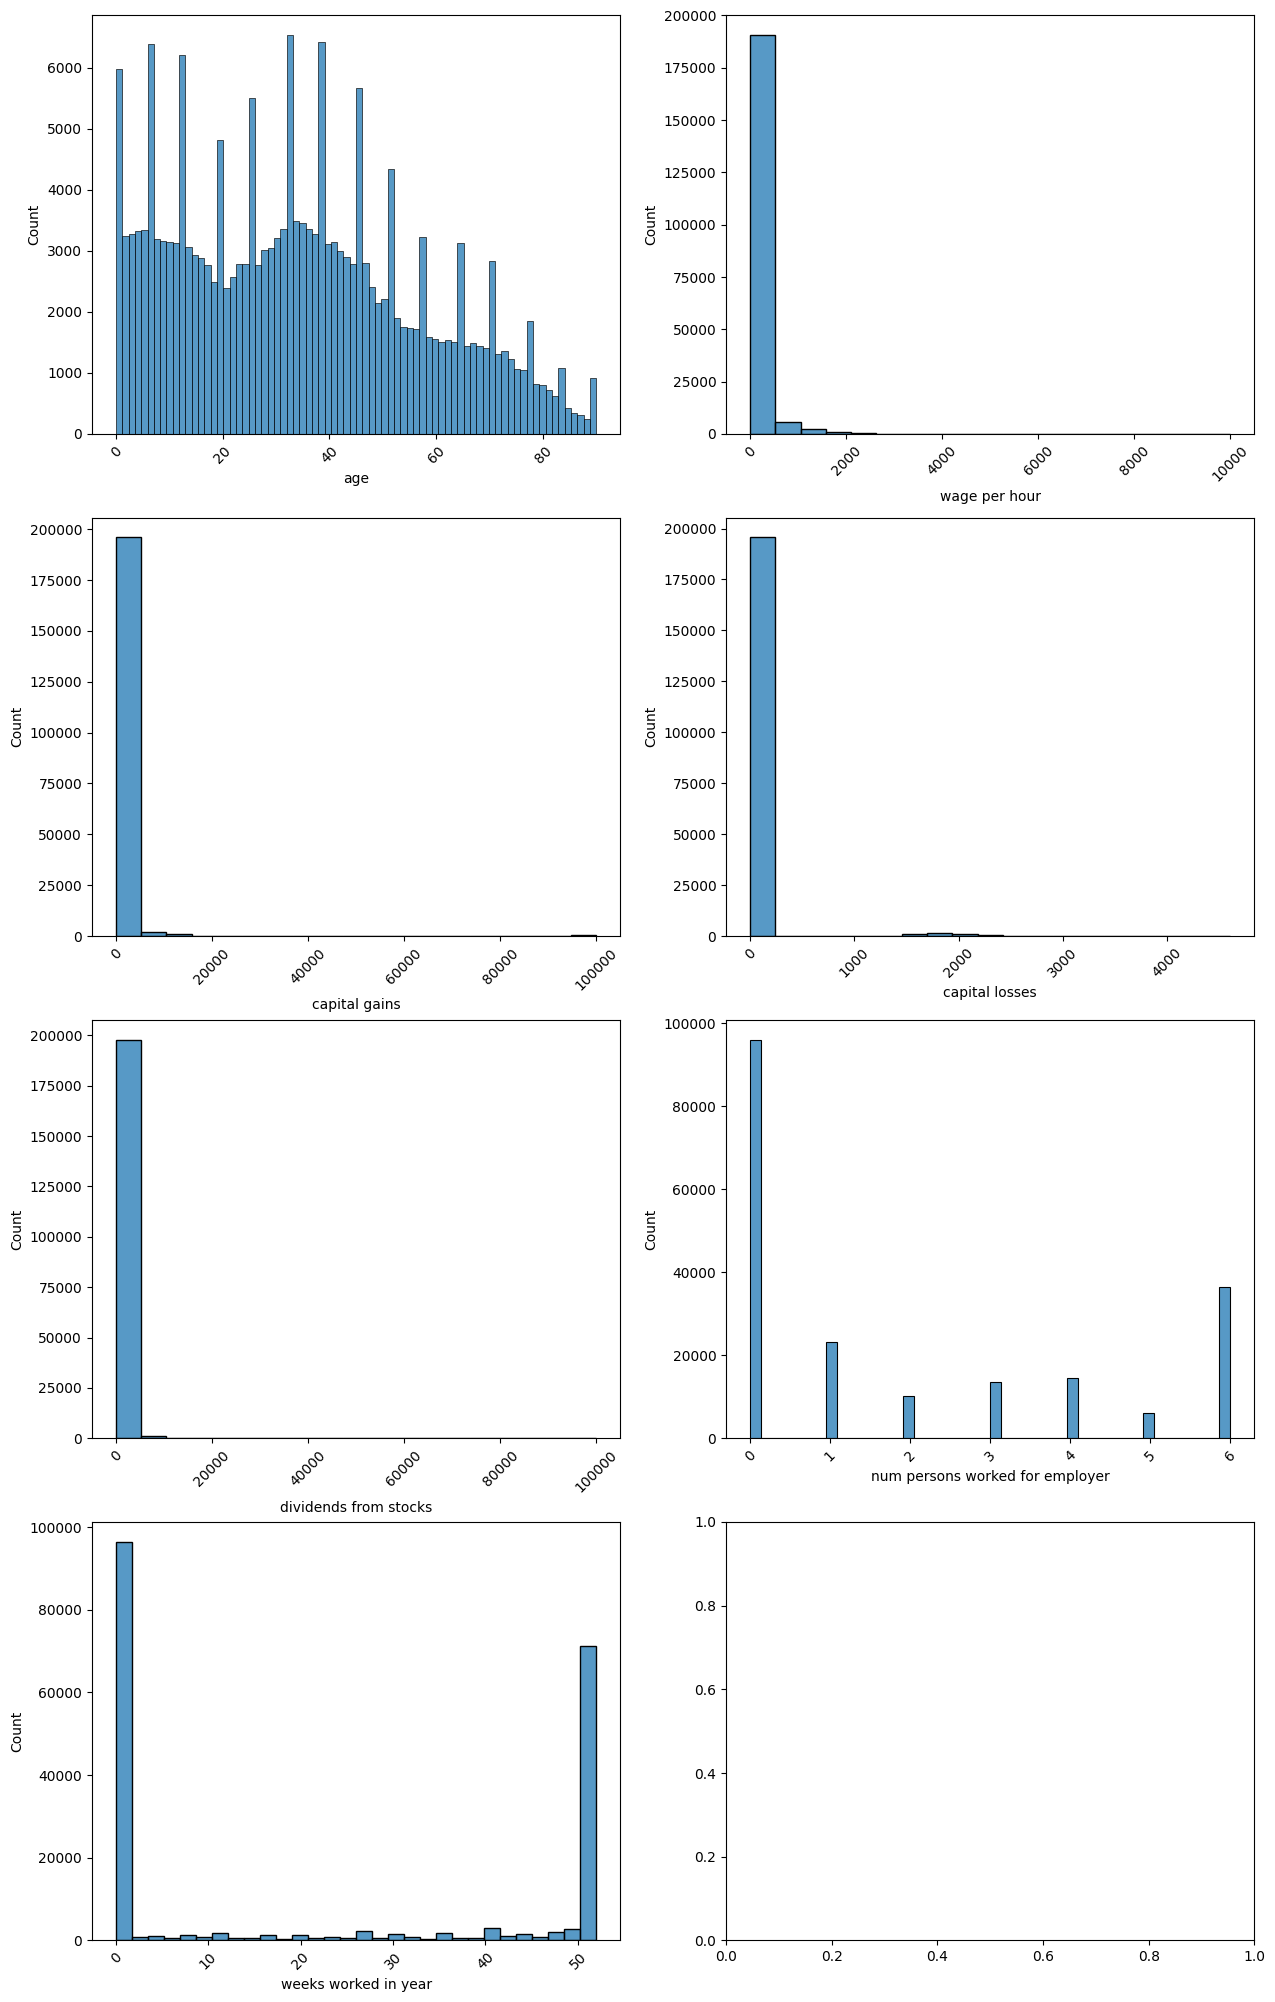

In [13]:
# we may consider scaling the continuous values if the range is high and we can also transform the same data if there's a high skew >0.5 or <-0.5

# we can view the caegorical values
fig, ax = plt.subplots(4, 2)
ax = ax.flatten()         # Convert axes to 1d array of length 9
fig.set_size_inches(15, 25)

for ax, col in zip(ax, df_continuous.columns):
  sns.histplot(df_continuous[col], ax = ax,)
  ax.tick_params(axis='x', labelrotation=45)

<Axes: >

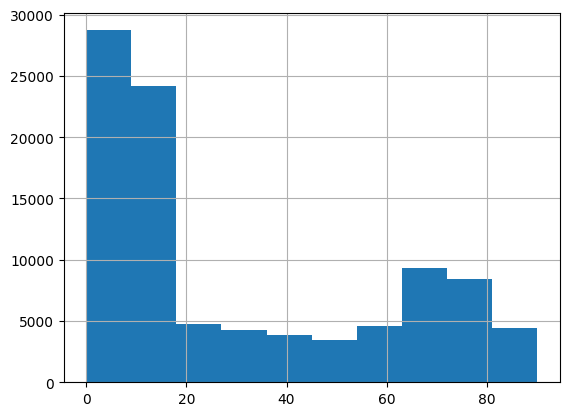

In [14]:
# We can see a lot of zero values here which provides a large amount of skew for this data, however given the nature of the data 
# it doesn't necessarily make sense to remove the data, rather it provides information about people who may be unemployed or have no investments

# for example, most of those not working are either young (<20) or old/retired (> 60) as shown below
df.loc[df['weeks worked in year'] == 0 , 'age'].hist()

In [15]:
# we can still look at the skew and kurotsis (removed due to length of output) of these continuous variables
# skew above 0.5 or below -0.5 is generally significant and for Kurtosis values above 2 or below -2 

for x in df_continuous.columns:
    print(f'\nThe skew of the variable {x} is: {skew(df[x])}')
    # print(f'The kurtosis of the variable {x} is: {kurtosis(df[x])}')

# we may consider applying a log transformation to reduce the skew.
# we may also want to scale 'wage per hour', 'capital gains', 'capital losses', 'dividends from stocks' as they have large value ranges

scaler = StandardScaler() # scale specific columns -> skew is unchanged

cols_to_transform = ['wage per hour', 'capital gains', 'capital losses', 'dividends from stocks']
for col in cols_to_transform:
    df[col] = scaler.fit_transform(df[[col]])

print(f'\nAfter transforming: {cols_to_transform}')
# now log transform the highly skewed columns 'wage per hour', 'capital gains', 'capital losses', 'dividends from stocks', 'num persons worked for employer'
for col in ['wage per hour', 'capital gains', 'capital losses', 'dividends from stocks', 'num persons worked for employer']:
    df[col] = np.log(df[[col]] + 1) # we need to add the 1 to the values as we cannot log transform the 0 values
    # df[col] = np.sqrt(df[[col]] + 1) # culd sqrt transform instead, again, we need to add the 1 to the values as we cannot sqrt transform the 0 values

# just looking at skew, skews are still large due to the large number of zeroes, but they are reduced
for col in cols_to_transform:
    print(f'\nThe transformed skew of the variable {col} is: {skew(df[col])}')




The skew of the variable age is: 0.3732876509407539

The skew of the variable wage per hour is: 8.935029357488652

The skew of the variable capital gains is: 18.990679572017093

The skew of the variable capital losses is: 7.632507318715383

The skew of the variable dividends from stocks is: 27.78629289133186

The skew of the variable num persons worked for employer is: 0.7515550301653675

The skew of the variable weeks worked in year is: 0.21016776188361566

After transforming: ['wage per hour', 'capital gains', 'capital losses', 'dividends from stocks']

The transformed skew of the variable wage per hour is: 4.2922500640165335

The transformed skew of the variable capital gains is: 8.607809572360628

The transformed skew of the variable capital losses is: 7.04626920142153

The transformed skew of the variable dividends from stocks is: 7.824561496557934


In [16]:
# one hot encode data for the categorical values 

ohe_df = pd.get_dummies(df.drop('target', axis=1), dtype=np.uint8)
target_df = df[['target']]

# one hot encoding produces 300+ features which is a lot of features, 
# however we can still use sklearn for this, as a simple model

In [17]:
# we have a class imbalance for the target variable 
target_df.value_counts()

# so we can choose to over or undersample the target. 
# However, this would mean we would lose a lot of data due to the 
# significance of the imbalance We can adjust the class weights in 
# the loss function instead, that way, we can keep all the data

# additionally, during evaluation, by using metrics that are robust to class 
# imbalance, such as ROC and AUC


target
0         187141
1          12382
Name: count, dtype: int64

In [18]:
# logistic regression with an L1 penalty, which is the Lasso regrssion, which 
# can shirink the coefficient of 'unimportant' features to 0 

# whilst the continuous features have been transformed, it may be better to 
# transform them to closer represent a normal distributions, bu using a quantile 
# transformation for example, but we have a lot of useful zero data 

# play around with the strength of the L1 penalty

model = LogisticRegression(penalty='l1', solver='liblinear', verbose=2)
cv = cross_validate(model, ohe_df, target_df['target'], scoring='roc_auc', cv=5, return_estimator=True)

[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

In [19]:
# model evaluated using ROC and AUC with a 5 fold cross validation 
# (again due to the class imbalance) 
cv 

{'fit_time': array([27.70334625, 21.06491423, 18.45087218, 73.24157643,  7.9165926 ]),
 'score_time': array([0.08845758, 0.08339047, 0.08309674, 0.09571314, 0.10168481]),
 'estimator': [LogisticRegression(penalty='l1', solver='liblinear', verbose=2),
  LogisticRegression(penalty='l1', solver='liblinear', verbose=2),
  LogisticRegression(penalty='l1', solver='liblinear', verbose=2),
  LogisticRegression(penalty='l1', solver='liblinear', verbose=2),
  LogisticRegression(penalty='l1', solver='liblinear', verbose=2)],
 'test_score': array([0.94162234, 0.938505  , 0.94075443, 0.93817434, 0.93527778])}

In [20]:
# presenting the data

log_odds = np.exp(cv['estimator'][0].coef_)[0]
sort_idx = np.argsort(log_odds)

dict(zip([ohe_df.columns[idx] for idx in sort_idx], log_odds[sort_idx]))

{'education_Less than 1st grade': np.float64(0.10840752157085332),
 'detailed household and family stat_Child <18 never marr not in subfamily': np.float64(0.18417559446420373),
 'education_Children': np.float64(0.1911427642305636),
 'class of worker_Without pay': np.float64(0.1969899650490145),
 'country of birth father_Guatemala': np.float64(0.24856232630860856),
 'sex_Female': np.float64(0.24889843071200618),
 'education_10th grade': np.float64(0.2794389665265382),
 'tax filer stat_Nonfiler': np.float64(0.2806775865229426),
 'country of birth self_Nicaragua': np.float64(0.2885202528953755),
 'education_9th grade': np.float64(0.28907167026687086),
 'education_5th or 6th grade': np.float64(0.2946301922335649),
 'marital stat_Married-A F spouse present': np.float64(0.30402741103588093),
 'full or part time employment stat_Children or Armed Forces': np.float64(0.3083658884490628),
 'country of birth father_El-Salvador': np.float64(0.3115157176507293),
 'major industry code_Social service

In [21]:
# We can evaluate the model by looking at the the regression coefficients for various variables

# some of the most important featues for those making more than $50k p.a., include:
# 'education_Doctorate degree(PhD EdD)',
# 'education_Prof school degree (MD DDS DVM LLB JD)'
# whilst some features that result in a reduction in the probability of making more than $50k p.a., include:
# 'education_Less than 1st grade'
# 'class of worker_Without pay'


# Because we have used OHE, the figures represent the change in odds 
# associated with the specific feature, rather than resulting in a unit change
# in probability as would be expected from a continuous variable

# things to try if given more time
# reduce overall dimensionality of the data, i.e., using PCA, but without losing too much information
# Scaling/transforming categorical data
# investigate and remove additional features by finding correaltion between continuous and categorical values
# deep learning if willing to invest in more data/time